In [1]:
import pandas as pd

from biological_fuzzy_logic_networks.DREAM_analysis.utils import (create_bfz, 
                                                                  prepare_cell_line_data, 
                                                                  cl_data_to_input)
import torch
import json
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from math import sqrt

def mean_RMSE(ground_truth, predictions, markers=["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"],
             non_marker_cols = ['cellID', 'cell_line', 'fileID', 'glob_cellID', 'time', 'treatment'],
             group_cols = ["cell_line", "treatment", "time"]):

    truth_non_marker_cols = set(ground_truth.columns).intersection(set(non_marker_cols))
    pred_non_marker_cols = set(predictions.columns).intersection(set(non_marker_cols))
    merge_cols = list(truth_non_marker_cols.intersection(pred_non_marker_cols))
    
    assert len(set(group_cols).intersection(merge_cols)) == len(group_cols)
    
    sel_truth = ground_truth[list(merge_cols)+markers]
    sel_pred = predictions[list(merge_cols)+markers]
    
    sel_truth = sel_truth.melt(id_vars=merge_cols, value_vars=markers, var_name="marker", value_name="true")
    sel_pred = sel_pred.melt(id_vars=merge_cols, value_vars=markers, var_name="marker", value_name="pred")
    
    assert len(sel_truth)==len(sel_pred)
   
    both = sel_truth.merge(sel_pred, on=merge_cols+["marker"]).reset_index(drop=True)
    
    RMSE = both.groupby(['cell_line', 'time', 'treatment', 'marker']).apply(lambda df: sqrt(sum((df["true"]-df["pred"])**2/len(df))))
    
    return RMSE.mean()

def get_scaler(run_folder):
    
    print(run_folder)
    ckpt = torch.load(f"{run_folder}model.pt")
    with open(f"{run_folder}{run_folder[47:-1]}_config.json") as f:
            config = json.load(f)
    print(config["valid_cell_lines"])
    model = create_bfz(f"{data_folder}DREAMdata/MEK_FAK_ERK.sif", config["network_class"])
    model.load_from_checkpoint(ckpt["model_state_dict"])

    cl_data = prepare_cell_line_data(**config) 
    
    
    (train_data,
     valid_data,
     train_inhibitors,
     valid_inhibitors,
     train_input,
     valid_input,
     train,
     valid,
     scaler ) = cl_data_to_input(
        data=cl_data,
        model=model,
        train_treatments=config["train_treatments"],
        valid_treatments=config["valid_treatments"],
        train_cell_lines=config["train_cell_lines"],
        valid_cell_lines=config["valid_cell_lines"],
        inhibition_value=config["inhibition_value"],
        minmaxscale=True,
        add_root_values=config["add_root_values"],
        input_value=1)

    return scaler

def get_test_data_formatted(run_folder):
    
    scaler = get_scaler(run_folder)

    test_output = pd.read_csv(f"{run_folder}test_output_states.csv", index_col=0).reset_index(drop=True)
    test_data = pd.read_csv(f"{run_folder}test_data.csv", index_col=0).reset_index(drop=True)



    test_unscaled = pd.DataFrame(scaler.inverse_transform(test_output[["ERK12", "FAK", "MEK12"]]),
                                columns=test_output.columns, index=test_output.index)
    test_output = test_output.rename(columns={"ERK12": "p.ERK"})
    test_output[["treatment", "cell_line", "time", "cellID", "fileID"]] = test_data[["treatment", "cell_line", "time", "cellID", "fileID"]]
    test_unscaled = test_unscaled.rename(columns={"ERK12": "p.ERK"})
    test_unscaled[["treatment", "cell_line", "time", "cellID", "fileID"]] = test_data[["treatment", "cell_line", "time", "cellID", "fileID"]]
    
    return test_output, test_unscaled

In [28]:
data_folder = "/dccstor/ipc1/CAR/DREAM/"

In [29]:
sc1_winner = pd.read_csv(f"{data_folder}Participants/SC1/icx_bxai_sc1.csv")
sc1_truth = pd.read_csv(f"{data_folder}DREAMdata/Challenge_data/sc1_test_time_aligned.csv", index_col=0)

#. Align timepoints
sc1_winner.loc[sc1_winner["time"]==18, "time"] = 17
sc1_winner.loc[sc1_winner["time"]==14, "time"] = 13

sc1_winner = sc1_winner.sort_values("glob_cellID")
sc1_truth = sc1_truth.sort_values("glob_cellID")

In [30]:
# Average over folds
run_base = f"{data_folder}Model/Test/MEK_FAK_ERK/26_"

test_outputs = []
test_unscaleds = []
for i in range(5):
    print(i)
    run_folder = f"{run_base}{i}/"
    test_output, test_unscaled = get_test_data_formatted(run_folder)
    
    test_outputs.append(test_output)
    test_unscaleds.append(test_unscaled)

0
/dccstor/ipc1/CAR/DREAM/Model/Test/MEK_FAK_ERK/26_0/
['HCC1187', 'HCC1500', 'HDQP1', 'MDAMB157', 'MDAMB361', 'OCUBM', 'T47D', 'ZR7530']
['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])
/tmp/ipykernel_3269364/488344303.py:67: DtypeWarning: Columns (43) have mixed types. Specify dtype option on i

1
/dccstor/ipc1/CAR/DREAM/Model/Test/MEK_FAK_ERK/26_1/
['BT549', 'CAL51', 'HCC1419', 'HCC38', 'MCF7', 'MDAMB134VI', 'MDAMB175VII', 'MX1']
['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])
/tmp/ipykernel_3269364/488344303.py:67: DtypeWarning: Columns (43) have mixed types. Specify dtype option on i

2
/dccstor/ipc1/CAR/DREAM/Model/Test/MEK_FAK_ERK/26_2/
['BT474', 'CAL148', 'CAL851', 'EFM192A', 'HBL100', 'HCC1569', 'HCC70', 'UACC893']
['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])
/tmp/ipykernel_3269364/488344303.py:67: DtypeWarning: Columns (43) have mixed types. Specify dtype option on i

3
/dccstor/ipc1/CAR/DREAM/Model/Test/MEK_FAK_ERK/26_3/
['BT20', 'DU4475', 'EVSAT', 'HCC1395', 'HCC1937', 'HCC2185', 'MDAMB415', 'MFM223']
['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])
/tmp/ipykernel_3269364/488344303.py:67: DtypeWarning: Columns (43) have mixed types. Specify dtype option on i

4
/dccstor/ipc1/CAR/DREAM/Model/Test/MEK_FAK_ERK/26_4/
['HCC1599', 'HCC1954', 'HCC3153', 'JIMT1', 'MDAMB453', 'MPE600', 'UACC812']
['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])
/tmp/ipykernel_3269364/488344303.py:67: DtypeWarning: Columns (43) have mixed types. Specify dtype option on i

In [22]:
test_output  = pd.concat(test_outputs)
test_unscaled = pd.concat(test_unscaleds, keys=[0, 1, 2, 3, 4], names=["CV", ""]).reset_index("CV", drop=False)

In [23]:
test_unscaled

,CV,MEK12,FAK,p.ERK,treatment,cell_line,time,cellID,fileID
,,,,,,,,,
0,0,1.998647,2.692034,5.23714,EGF,AU565,9.0,1,35
1,0,0.912902,1.832598,3.57578,EGF,AU565,9.0,1,68
2,0,0.257447,0.643212,3.40542,EGF,AU565,9.0,2,35
3,0,1.469010,2.401426,4.31995,EGF,AU565,9.0,2,68
4,0,1.332787,2.431178,3.86537,EGF,AU565,9.0,3,35
...,...,...,...,...,...,...,...,...,...
320302,4,2.019317,3.440238,4.05029,iPKC,MDAMB436,9.0,12900,2115
320303,4,0.744587,1.345736,4.00999,iPKC,MDAMB436,9.0,12901,2115
320304,4,0.142821,0.606963,2.40088,iPKC,MDAMB436,9.0,12902,2115


<AxesSubplot:xlabel='CV', ylabel='p.ERK'>

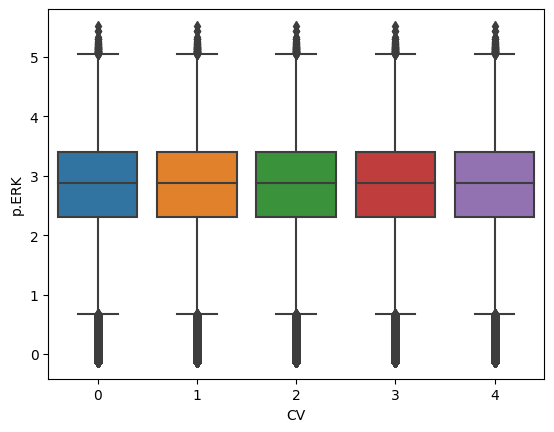

In [24]:
sns.boxplot(data=test_unscaled, x="CV", y="p.ERK")

In [7]:
test_output = test_output.groupby(["cell_line", "treatment", 'time', 'cellID', "fileID"]).mean().reset_index(drop=False)
test_unscaled = test_unscaled.groupby(["cell_line", "treatment", 'time', 'cellID', "fileID"]).mean().reset_index(drop=False)


In [8]:
truth_subset = sc1_truth[sc1_truth["time"]==9].reset_index(drop=True)
winner_subset = sc1_winner[sc1_winner["time"]==9].reset_index(drop=True)

In [9]:
mean_RMSE(truth_subset, winner_subset, markers=["p.ERK"])

0.6298291534468246

In [10]:
mean_RMSE(truth_subset, test_unscaled, markers=["p.ERK"])

0.8943791989485648

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


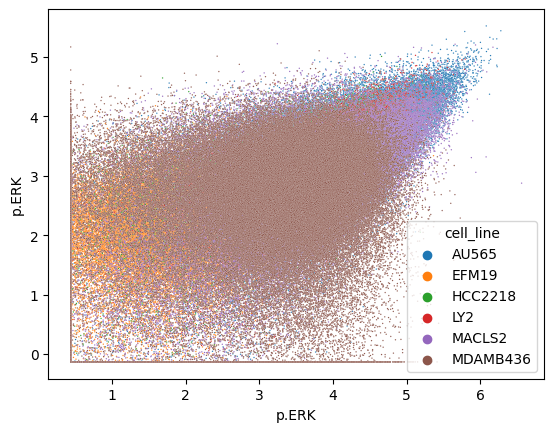

In [11]:
sns.scatterplot(x=truth_subset["p.ERK"], y=test_unscaled["p.ERK"], hue=test_unscaled["cell_line"], s=1)

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


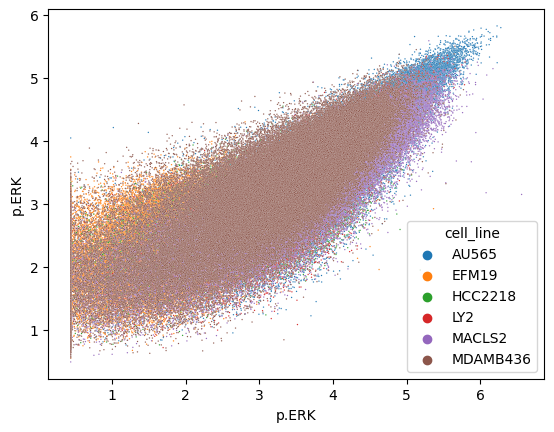

In [12]:
sns.scatterplot(x=truth_subset["p.ERK"], y=winner_subset["p.ERK"], hue=winner_subset["cell_line"], s=1)

In [14]:
test_unscaleds[0]

,MEK12,FAK,p.ERK,treatment,cell_line,time,cellID,fileID
0,1.998647,2.692034,5.23714,EGF,AU565,9.0,1,35
1,0.912902,1.832598,3.57578,EGF,AU565,9.0,1,68
2,0.257447,0.643212,3.40542,EGF,AU565,9.0,2,35
3,1.469010,2.401426,4.31995,EGF,AU565,9.0,2,68
4,1.332787,2.431178,3.86537,EGF,AU565,9.0,3,35
...,...,...,...,...,...,...,...,...
320302,2.000982,3.440238,4.05029,iPKC,MDAMB436,9.0,12900,2115
320303,0.737084,1.345736,4.00999,iPKC,MDAMB436,9.0,12901,2115
320304,0.140432,0.606963,2.40088,iPKC,MDAMB436,9.0,12902,2115
320305,0.845761,1.831821,3.32045,iPKC,MDAMB436,9.0,12903,2115


In [15]:
test_unscaleds[1]

,MEK12,FAK,p.ERK,treatment,cell_line,time,cellID,fileID
0,2.016962,2.692034,5.23714,EGF,AU565,9.0,1,35
1,0.921911,1.832598,3.57578,EGF,AU565,9.0,1,68
2,0.260839,0.643212,3.40542,EGF,AU565,9.0,2,35
3,1.482785,2.401426,4.31995,EGF,AU565,9.0,2,68
4,1.345395,2.431178,3.86537,EGF,AU565,9.0,3,35
...,...,...,...,...,...,...,...,...
320302,2.019317,3.440238,4.05029,iPKC,MDAMB436,9.0,12900,2115
320303,0.744587,1.345736,4.00999,iPKC,MDAMB436,9.0,12901,2115
320304,0.142821,0.606963,2.40088,iPKC,MDAMB436,9.0,12902,2115
320305,0.854195,1.831821,3.32045,iPKC,MDAMB436,9.0,12903,2115


In [27]:
print(truth_subset["p.ERK"].max())
print(truth_subset["p.ERK"].min())

6.5593
0.442259


In [28]:
print(test_unscaled["p.ERK"].max())
print(test_unscaled["p.ERK"].min())


5.52375
-0.13242803900000047


In [20]:
truth_subset

,glob_cellID,cell_line,treatment,time,cellID,fileID,p.ERK,p.Akt.Ser473.,p.S6,p.HER2,p.PLCg2
0,31326,AU565,EGF,9.0,1,35,5.913096,4.565520,7.70364,6.488928,3.286285
1,31327,AU565,EGF,9.0,1,68,4.486310,3.928950,5.60473,4.708056,1.800372
2,31328,AU565,EGF,9.0,2,35,4.146357,2.952235,4.68711,4.962875,2.353157
3,31329,AU565,EGF,9.0,2,68,5.188804,5.484557,7.06001,5.827561,2.733310
4,31330,AU565,EGF,9.0,3,35,4.930940,3.984473,6.50938,5.016321,1.876391
...,...,...,...,...,...,...,...,...,...,...,...
320302,2357752,MDAMB436,iPKC,9.0,12900,2115,4.910816,5.125619,5.87664,5.483383,2.892862
320303,2357753,MDAMB436,iPKC,9.0,12901,2115,4.183147,5.380833,2.39632,4.645884,2.697231
320304,2357754,MDAMB436,iPKC,9.0,12902,2115,3.960765,5.230970,3.96489,4.428557,3.341673
320305,2357755,MDAMB436,iPKC,9.0,12903,2115,3.963794,5.153449,2.49665,3.894383,1.283129


In [31]:
truth_scaler = MinMaxScaler()
truth_scaled = truth_subset.copy()
truth_scaled[["p.ERK", "p.Akt.Ser473.", 
              "p.S6", "p.HER2", "p.PLCg2"]] = truth_scaler.fit_transform(truth_subset[["p.ERK", "p.Akt.Ser473.", "p.S6", 
                                                            "p.HER2", "p.PLCg2"]])


winner_scaler = MinMaxScaler()
winner_scaled = winner_subset.copy()
winner_scaled[["p.ERK", "p.Akt.Ser473.", 
              "p.S6", "p.HER2", "p.PLCg2"]] = winner_scaler.fit_transform(winner_subset[["p.ERK", "p.Akt.Ser473.", "p.S6", 
                                                            "p.HER2", "p.PLCg2"]])

test_scaler = MinMaxScaler()
test_scaled = test_output.copy()
test_scaled[["p.ERK"]] = test_scaler.fit_transform(test_output[["p.ERK"]])


In [32]:
mean_RMSE(truth_scaled, winner_scaled, markers=["p.ERK"])

0.10835663426202762

In [33]:
mean_RMSE(truth_scaled, test_scaled, markers=["p.ERK"])

0.27080890888408876

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

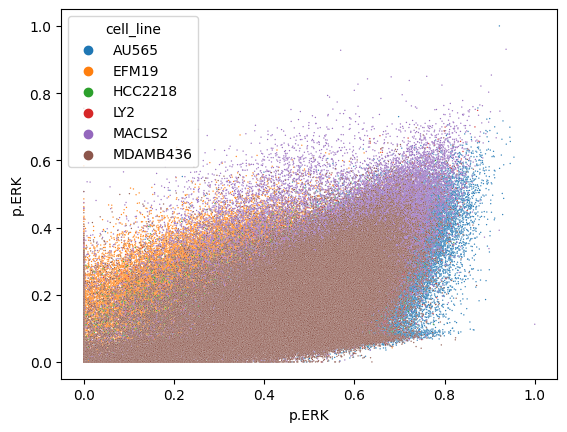

In [34]:
sns.scatterplot(x=truth_scaled["p.ERK"], y=test_scaled["p.ERK"], hue=test_scaled["cell_line"], s=1)

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

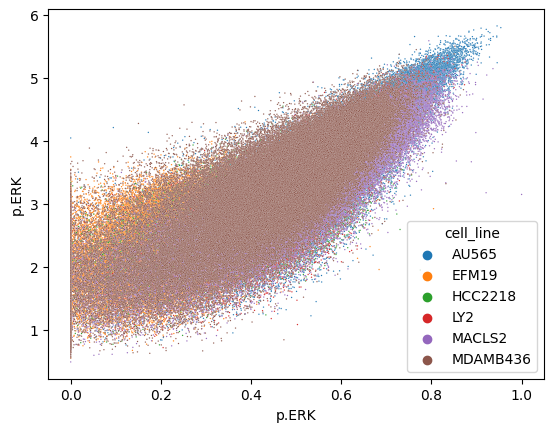

In [35]:
sns.scatterplot(x=truth_scaled["p.ERK"], y=winner_subset["p.ERK"], hue=winner_scaled["cell_line"], s=1)

In [23]:
test_cell_lines = ["AU565", "MDAMB436", "EFM19", "HCC2218", "LY2", "MACLS2"]
test_file_paths = [f"{data_folder}DREAMdata/{CL}.csv" for CL in test_cell_lines]

cl_data = prepare_cell_line_data(
        data_file=test_file_paths,
        time_point=9)

(   train_data,
    valid_data,
    train_inhibitors,
    valid_inhibitors,
    train_input,
    valid_input,
    train,
    valid,
    scaler,
)= cl_data_to_input(
    data=cl_data,
    model=model,
    train_treatments=None,
    valid_treatments=None,
    train_cell_lines=None,
    valid_cell_lines=None,
    inhibition_value=1,
    minmaxscale=True,
    add_root_values=False,
    input_value=None,
    root_nodes=None
)

all_test_data = {node: torch.cat((train_data[node], valid_data[node])) for node in train_data.keys()}
all_test_input = {node: torch.cat((train_input[node], valid_input[node])) for node in train_input.keys()}
all_test_inhibitors = {node: torch.cat((train_inhibitors[node], valid_inhibitors[node])) for node in train_inhibitors.keys()}
all_test = (pd.concat([train, valid])[["MEK12", "FAK", "ERK12", "treatment"]]).reset_index(drop=True)

['AU565' 'MDAMB436' 'EFM19' 'HCC2218' 'LY2' 'MACLS2']


In [24]:
a = cl_data_to_input(
    data=cl_data,
    model=model,
    train_treatments=None,
    valid_treatments=None,
    train_cell_lines=None,
    valid_cell_lines=None,
    inhibition_value=1,
    minmaxscale=True,
    add_root_values=False,
    input_value=None,
    root_nodes=None
)

In [25]:
with torch.no_grad():
    model.set_network_ground_truth(all_test_data)
    model.sequential_update(model.root_nodes, all_test_inhibitors)